In [31]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [32]:
sys.path.append(os.path.abspath("../scripts"))

In [33]:
from db_utils import connect_to_database, fetch_data, close_connection
from queries import query_telecom_data

In [34]:
# Connect to the database using parameters from the .env file
conn = connect_to_database()

Database connection successful!


In [35]:
query="SELECT * from xdr_data;"

In [36]:
# Fetch data using the query
if conn:
    telecom_data = fetch_data(conn, query)
    close_connection(conn)

# Display the first few rows of the data
if telecom_data is not None:
    print(telecom_data.head())

Data fetched successfully!
Database connection closed!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                

In [39]:
# Aggregate metrics per user
engagement_data = telecom_data.groupby("MSISDN/Number").agg({
    "Bearer Id": "count",  # Number of sessions
    "Dur. (ms)": "sum",  # Total session duration
    "Total DL (Bytes)": "sum",  # Total download traffic
    "Total UL (Bytes)": "sum"   # Total upload traffic
}).reset_index()

# Add total traffic column (DL + UL)
engagement_data["Total Traffic (Bytes)"] = (
    engagement_data["Total DL (Bytes)"] + engagement_data["Total UL (Bytes)"]
)

# Rename columns for clarity
engagement_data.rename(columns={
    "Bearer Id": "Session Frequency",
    "Dur. (ms)": "Total Session Duration (ms)",
}, inplace=True)

# Display the first few rows
engagement_data.head()


,MSISDN/Number,Session Frequency,Total Session Duration (ms),Total DL (Bytes),Total UL (Bytes),Total Traffic (Bytes)
0,3.360100e+10,1,116720.0,8.426375e+08,36053108.0,8.786906e+08
1,3.360100e+10,1,181230.0,1.207552e+08,36104459.0,1.568596e+08
2,3.360100e+10,1,134969.0,5.566597e+08,39306820.0,5.959665e+08
3,3.360101e+10,1,49878.0,4.019932e+08,20327526.0,4.223207e+08
4,3.360101e+10,2,37104.0,1.363130e+09,94280527.0,1.457411e+09


In [40]:
# Top 10 users by session frequency
top_users_frequency = engagement_data.nlargest(10, "Session Frequency")

# Top 10 users by total session duration
top_users_duration = engagement_data.nlargest(10, "Total Session Duration (ms)")

# Top 10 users by total traffic
top_users_traffic = engagement_data.nlargest(10, "Total Traffic (Bytes)")

# Display results
print("Top 10 Users by Session Frequency:\n", top_users_frequency)
print("Top 10 Users by Total Session Duration:\n", top_users_duration)
print("Top 10 Users by Total Traffic:\n", top_users_traffic)


Top 10 Users by Session Frequency:
        MSISDN/Number  Session Frequency  Total Session Duration (ms)  \
13526   3.362632e+10                 18                    8791927.0   
6437    3.361489e+10                 17                    9966898.0   
13180   3.362578e+10                 17                   18553754.0   
37052   3.365973e+10                 16                    4035428.0   
76363   3.367588e+10                 15                    4865947.0   
92923   3.376054e+10                 15                    9279434.0   
65118   3.366716e+10                 13                    8744914.0   
666     3.360313e+10                 12                    6287761.0   
1279    3.360452e+10                 12                    5207990.0   
13994   3.362708e+10                 12                    4703516.0   

       Total DL (Bytes)  Total UL (Bytes)  Total Traffic (Bytes)  
13526      7.301517e+09       669650721.0           7.971167e+09  
6437       8.156743e+09       6894830

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to normalize
metrics = ["Session Frequency", "Total Session Duration (ms)", "Total Traffic (Bytes)"]

# Normalize metrics using MinMaxScaler
scaler = MinMaxScaler()
engagement_data_normalized = engagement_data.copy()
engagement_data_normalized[metrics] = scaler.fit_transform(engagement_data[metrics])

# Display normalized data
print(engagement_data_normalized.head())


   MSISDN/Number  Session Frequency  Total Session Duration (ms)  \
0   3.360100e+10           0.055556                     0.005908   
1   3.360100e+10           0.055556                     0.009387   
2   3.360100e+10           0.055556                     0.006892   
3   3.360101e+10           0.055556                     0.002304   
4   3.360101e+10           0.111111                     0.001615   

   Total DL (Bytes)  Total UL (Bytes)  Total Traffic (Bytes)  
0      8.426375e+08        36053108.0               0.095931  
1      1.207552e+08        36104459.0               0.014026  
2      5.566597e+08        39306820.0               0.063851  
3      4.019932e+08        20327526.0               0.044148  
4      1.363130e+09        94280527.0               0.161598  


In [43]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_data_normalized["Cluster"] = kmeans.fit_predict(engagement_data_normalized[metrics])

# Display cluster assignment
print(engagement_data_normalized["Cluster"].value_counts())


Cluster
2    81700
0    21159
1     3997
Name: count, dtype: int64


In [45]:
# Analyze clusters
cluster_summary = engagement_data_normalized.groupby("Cluster").agg({
    "Session Frequency": ["min", "max", "mean"],
    "Total Session Duration (ms)": ["min", "max", "mean"],
    "Total Traffic (Bytes)": ["min", "max", "mean"]
})

# Display cluster summary
cluster_summary.head()


Session Frequency                     Total Session Duration (ms)  \
                      min       max      mean                         min   
Cluster                                                                     
0                0.055556  0.222222  0.121377                    0.000598   
1                0.166667  1.000000  0.236566                    0.002274   
2                0.000000  0.111111  0.057975                    0.000000   

                            Total Traffic (Bytes)                      
              max      mean                   min       max      mean  
Cluster                                                                
0        0.170796  0.011213              0.028477  0.213626  0.125466  
1        1.000000  0.030465              0.119454  1.000000  0.256548  
2        0.084451  0.005410              0.000000  0.158159  0.052564

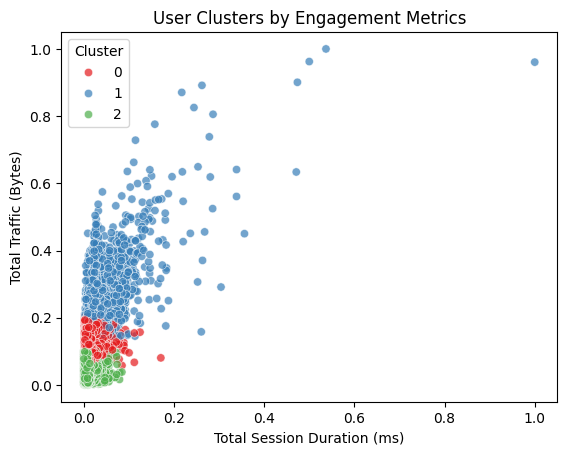

In [46]:
# Scatter plot for two metrics
sns.scatterplot(
    x="Total Session Duration (ms)",
    y="Total Traffic (Bytes)",
    hue="Cluster",
    data=engagement_data_normalized,
    palette="Set1",
    alpha=0.7
)
plt.title("User Clusters by Engagement Metrics")
plt.xlabel("Total Session Duration (ms)")
plt.ylabel("Total Traffic (Bytes)")
plt.show()


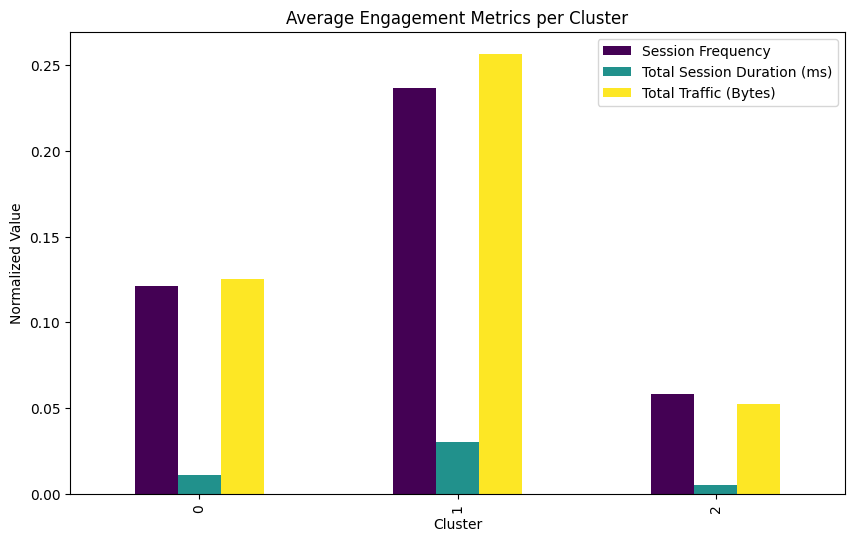

In [47]:
# Average metrics per cluster
avg_metrics = cluster_summary.xs("mean", level=1, axis=1)

# Plot bar chart
avg_metrics.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Average Engagement Metrics per Cluster")
plt.ylabel("Normalized Value")
plt.xlabel("Cluster")
plt.show()


In [49]:
# Save engagement data to CSV
engagement_data_normalized.to_csv("..\Data\engagement_data.csv", index=False)


In [ ]:
from scipy.spatial.distance import euclidean

# Engagement Score: Distance from less engaged cluster
engagement_centroid = kmeans_engagement.cluster_centers_[0]  # Assuming Cluster 0 is less engaged
experience_centroid = kmeans_experience.cluster_centers_[0]  # Assuming Cluster 0 is worst experience

# Calculate engagement and experience scores
engagement_data_normalized["Engagement Score"] = engagement_data_normalized.apply(
    lambda row: euclidean(
        row[["Session Frequency", "Total Session Duration (ms)", "Total Traffic (Bytes)"]].values,
        engagement_centroid
    ), axis=1
)


